In [36]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import warnings; warnings.simplefilter('ignore')

%matplotlib inline




In [37]:
train_values = pd.read_csv('train_values.csv')
train_labels = pd.read_csv('train_labels.csv')
test_values = pd.read_csv('test_values.csv')


In [38]:
train_values.merge(train_labels, how= 'left', on= 'building_id')

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,6,3,n,r,...,0,0,0,0,0,0,0,0,0,2
260597,669485,17,715,2060,2,0,6,5,t,r,...,0,0,0,0,0,0,0,0,0,3
260598,602512,17,51,8163,3,55,6,7,t,r,...,0,0,0,0,0,0,0,0,0,3
260599,151409,26,39,1851,2,10,14,6,t,r,...,0,0,0,0,0,0,0,0,0,2


In [39]:
def rm_building_id(df):
    
    '''Function to remove the "building_id" column from the datasets.
    This is a number randomly assigned and has no use for our 
    classification problem.'''
    
    df = df.drop(['building_id'], axis = 1)
    
    return df
    
    
    

In [40]:
# Remove "building_id columns using rm_building_id function"

train_values = rm_building_id(train_values)
train_labels = rm_building_id(train_labels)



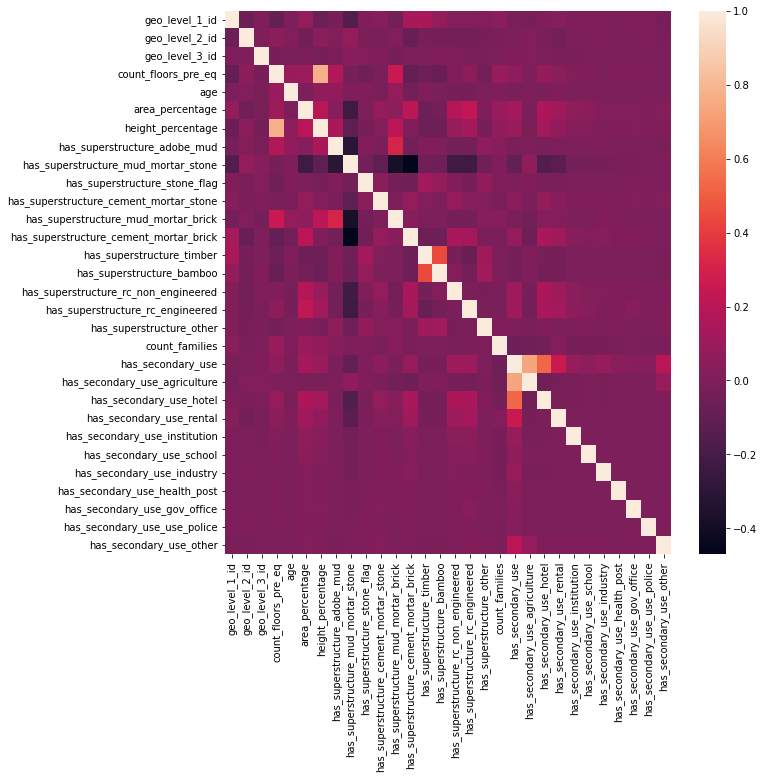

In [41]:
plt.figure(figsize=[10,10])
sns.heatmap(train_values.corr())

In [42]:
def make_encoded_array(df,bins = 20):
    
    '''This function gets a dataframe and transforms it in an array ready to 
    be used to make predictions.'''
    
    all_float =df.select_dtypes('int64') #  Segregate "int64" columns
    no_float = df.select_dtypes(exclude = 'int64')  # Sgregate non "int64" columns
    
    
    #  The next step transforms "all_float" from continuous to categorical acording to the
    #  number of bins selected on the function 
    
    from sklearn.preprocessing import KBinsDiscretizer 

    discrete = KBinsDiscretizer(n_bins= bins, encode='ordinal', strategy='uniform')
    ints = discrete.fit_transform(all_float)
    all_float = pd.DataFrame(ints, columns=all_float.columns)
    
    
    # The next bit of code onehotencodes the columns in all_float to transform the data in binary
    
    from sklearn.preprocessing import OneHotEncoder
    encoder = OneHotEncoder()
    all_float = encoder.fit_transform(all_float)  #Onehotencode numerical values 
    all_float = all_float.toarray()
    
    
    # The next step transforms the labels on no_float to categorical and then "onehotencodes it".
    
    from sklearn.preprocessing import LabelEncoder

    for column in no_float.columns:
        l_encoder = LabelEncoder()
        no_float[column] = l_encoder.fit_transform(no_float[column]) # Transforms to categorical
        
#     no_float = encoder.fit_transform(no_float).toarray() # Onehotencodes it.
    
    
    # The next bit of code merges both arrays ready to be used for predictions
    
    merged = np.concatenate([no_float,ints],axis = 1)  
    
    return merged
    
     
    

In [43]:
train_values.shape

(260601, 38)

In [44]:
test_values.shape

(86868, 39)

In [45]:
train_labels.shape


(260601, 1)

In [46]:
# Here we make test train datasets
X = make_encoded_array(train_values,300)
Y = make_encoded_array(test_values, 300)


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, train_labels, test_size=0.05, random_state=42)

In [47]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
params = {
    'bootstrap': [True],
    'max_depth': [40],
    'max_features': [20],
    'min_samples_leaf': [1],
    'min_samples_split': [6],
    'n_estimators': [400 ],
    'warm_start': [ False]}

clf = RandomForestClassifier()

grid = GridSearchCV(estimator = clf, verbose=3, cv= 5, n_jobs = -1, param_grid = params)

grid.fit(X_train,y_train)



Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [40],
                         'max_features': [20], 'min_samples_leaf': [1],
                         'min_samples_split': [6], 'n_estimators': [400],
                         'warm_start': [False]},
             verbose=3)

In [48]:
grid.best_params_

{'bootstrap': True,
 'max_depth': 40,
 'max_features': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 400,
 'warm_start': False}

In [49]:
best_grid = grid.best_estimator_

In [50]:

grid_accuracy = best_grid.predict(X_test)

In [51]:
f1_score(y_test, grid_accuracy,average='weighted')

0.7394850878862577

In [52]:
X_train.shape

(247570, 38)

In [53]:
ids = test_values['building_id']

In [54]:
test_values = rm_building_id(test_values)

In [55]:
test_values = make_encoded_array(test_values,300)                                

In [56]:
prediction_test = best_grid.predict(test_values)

In [57]:
test_send = pd.DataFrame({'building_id':ids, 'damage_grade':prediction_test})
test_send =test_send.set_index('building_id')
#test_send['damage_grade']=test_send['damage_grade'].astype('int64')
test_send.to_csv(r'C:\Users\jdrfi\Google Drive\Intro to data science\Git\Righter_Comp\test_send.csv')

                          

from sklearn.ensemble import GradientBoostingClassifier

classifier = GradientBoostingClassifier()
classifier.fit(X_train,y_train)


neural_prediction = classifier.predict(X_test)

neural_score = f1_score(y_test,neural_prediction, average='micro')

neural_score